## Data loading and Pre-Processing

### Download data

In [1]:
# ! wget https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_training.csv
# ! mv MLchallenge2_training.csv train_data.csv

# ! wget https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_testing_inputs.csv
# ! mv MLchallenge2_testing_inputs.csv test_data.csv

### Do Basic Imports

In [85]:
import numpy as np
from tensorflow import keras
import pandas
from matplotlib import pyplot as plt
from math import isnan
from scipy.stats import norm

### Read training data

Read training data from .csv file and convert to a numpy array

In [116]:
train_csv = pandas.read_csv("/work/halld2/home/kishan/AI Tracking/train_data.csv")
train_csv.dropna(inplace=True)
train_x = np.array(train_csv)

In [117]:
test_csv = pandas.read_csv("/work/halld2/home/kishan/AI Tracking/newTestData.csv")
test_csv.dropna(inplace=True)
test_data = np.array(test_csv)

In [118]:
train_x.shape

(112394, 150)

In [119]:
test_data.shape

(0, 150)

In [120]:
train_data = np.reshape(train_x, (train_x.shape[0], 25, 6))
test_data = np.reshape(test_data, (test_data.shape[0], 25, 6))

## Min-Max normalization

In [121]:
mn = []
mx = []
for i in range(train_data.shape[2]):
    minimum = train_data[:, :, i].min()
    maximum = train_data[:, :, i].max()
    train_data[:, :, i] = (train_data[:, :, i] - minimum) / (maximum-minimum)
    mn.append(minimum)
    mx.append(maximum)

In [122]:
for i in range(train_data.shape[2]):
    print(train_data[:, :, i].min(), train_data[:, :, i].max())

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


### Parse Data


In [98]:
# def parser(data, randomInput):
#     nStep = 6
#     nInputs = 6
#     nOutputs = 6
#     inputLayers = 23

#     x = []
#     y = []

#     for i in range(len(data)):
#         index = 0 
#         one_set_x = []
#         one_set_y = []
#         while index < 138:
#             mid = index+nInputs
#             one_set_x.append(data[i][index:mid]) # + data[i,mid+3] # later fix to get z value
#             # TimeSeries needs a 3D output too; so when using Time you need .append
#             one_set_y.append(data[i][mid:mid+nOutputs])
#             if len(one_set_x) == inputLayers:
#                 x.append(one_set_x)
#                 y.append(one_set_y)
#                 one_set_x = one_set_x[1:]
#                 # if using Time uncommend
#                 one_set_y = one_set_y[1:]
#             index += nStep

#     x = np.array(x)
#     y = np.array(y)
#     print("shape of x: ", x.shape)
#     print("shape of y: ", y.shape)
#     return x, y

train_data = np.reshape(train_x, (train_x.shape[0], 25, 6))
test_data = np.reshape(test_data, (test_data.shape[0], 25, 6))

In [99]:
print(train_data.shape, test_data.shape)

(112394, 25, 6) (0, 25, 6)


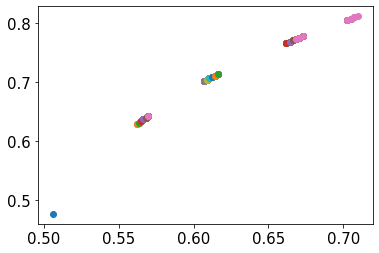

(1910698, 7, 6) (1910698, 1, 6)


In [100]:
train_x = []
train_y = []
for i in range(17):
    xs = train_data[:, i:7+i, :]
    ys = train_data[:, 7+i:8+i, :]
    train_x.extend(xs)
    train_y.extend(ys)
    plt.scatter(train_data[1, i:7+i, 0], train_data[1, i:7+i, 1])
plt.show()

train_x = np.array(train_x)
train_y = np.array(train_y)
print(train_x.shape, train_y.shape)

In [101]:
test_x = test_data[:, :24, :]
test_y = test_data[:, 24:, :]
print(test_x.shape, test_y.shape)

(0, 24, 6) (0, 1, 6)


In [102]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

In [103]:
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(1528558, 7, 6) (1528558, 1, 6)
(382140, 7, 6) (382140, 1, 6)
(0, 24, 6) (0, 1, 6)


In [104]:
train_y = np.squeeze(train_y)
val_y = np.squeeze(val_y)
test_y = np.squeeze(test_y)

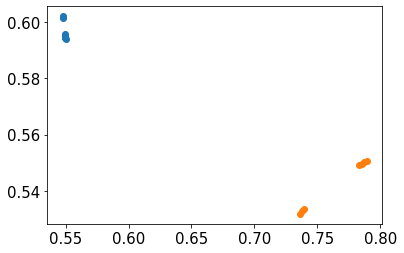

In [105]:
plt.scatter(train_x[1, :, 0], train_x[1, :, 1])
plt.scatter(train_x[2, :, 0], train_x[2, :, 1])
plt.show()

## Model

In [106]:
def RNNTime(x):
    x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', batch_input_shape=(128,None,6), stateful=False, return_sequences=True)(x)
    x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
    x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False)(x)
#     x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'))(x)
#     x = keras.layers.TimeDistributed(keras.layers.Dense(6, activation='linear'))(x)
    x = keras.layers.Dense(6, activation='linear')(x)
    return x

def RNNTimeStateful(x):
    # https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
    x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=True, return_sequences=True)(x)
    x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=True, return_sequences=True)(x)
    x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=True, return_sequences=True)(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'))(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(6, activation='sigmoid'))(x)
    return x

### Build model

Choose Input type, currently trying to convert 128 batch size for training to 1 for when I use test data

Set a constant seed to test if model is just bad or bad random values?

~~Categorizing the values of the outputs, does not work with the rest of the code!~~
- moved to depricated at the very bottom of notebook

Choose model.

In [107]:
# inputs = keras.layers.Input((None,6), batch_size=1)
inputs = keras.layers.Input((None,6))
x = RNNTime(inputs)
# x = RNNTimeStateful(inputs)
model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")

### Compile Model

In [108]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.85, patience=5, min_delta=0.00001, min_lr=1e-6,verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=20, verbose=1, mode='auto',
                               baseline=None, restore_best_weights=True)

optimizer = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)

model.compile(optimizer=optimizer, loss="mae", metrics=["mse"])

model.summary()

Model: "RNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 6)]         0         
                                                                 
 input_lstm1 (LSTM)          (None, None, 128)         69120     
                                                                 
 lstm2 (LSTM)                (None, None, 64)          49408     
                                                                 
 lstm3 (LSTM)                (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 131,142
Trainable params: 131,142
Non-trainable params: 0
_________________________________________________________________


## Fit model

Gets stuck on loss=105 for ~10 epochs for some reason...


In [109]:
print(train_x.shape, train_y.shape)
history = model.fit(x=train_x, y=train_y, batch_size=1256, epochs=100, shuffle=True, verbose=1, callbacks=[reduce_lr, early_stopping], validation_data=(val_x, val_y))


(1528558, 7, 6) (1528558, 6)
Epoch 1/100
1218/1218 [==============================] - 13s 7ms/step - loss: 0.0540 - mse: 0.0174 - val_loss: 0.0103 - val_mse: 3.2033e-04 - lr: 1.0000e-04
Epoch 2/100
1218/1218 [==============================] - 7s 6ms/step - loss: 0.0089 - mse: 2.8626e-04 - val_loss: 0.0117 - val_mse: 3.2288e-04 - lr: 1.0000e-04
Epoch 3/100
1218/1218 [==============================] - 7s 6ms/step - loss: 0.0081 - mse: 2.7287e-04 - val_loss: 0.0098 - val_mse: 2.9144e-04 - lr: 1.0000e-04
Epoch 4/100
1218/1218 [==============================] - 7s 6ms/step - loss: 0.0081 - mse: 2.7496e-04 - val_loss: 0.0084 - val_mse: 2.7232e-04 - lr: 1.0000e-04
Epoch 5/100
1218/1218 [==============================] - 7s 6ms/step - loss: 0.0075 - mse: 2.7214e-04 - val_loss: 0.0087 - val_mse: 2.9008e-04 - lr: 1.0000e-04
Epoch 6/100
1218/1218 [==============================] - 7s 6ms/step - loss: 0.0075 - mse: 2.7549e-04 - val_loss: 0.0084 - val_mse: 3.0127e-04 - lr: 1.0000e-04
Epoch 7/100
12

## Model Evaluation

In [18]:
# model.save("/work/data_science/kishan/surrogate_ldrd/lstm_tracking")


INFO:tensorflow:Assets written to: /work/data_science/kishan/surrogate_ldrd/lstm_tracking/assets


INFO:tensorflow:Assets written to: /work/data_science/kishan/surrogate_ldrd/lstm_tracking/assets


In [110]:
model.save("/work/data_science/kishan/surrogate_ldrd/lstm_tracking_v2")


INFO:tensorflow:Assets written to: /work/data_science/kishan/surrogate_ldrd/lstm_tracking_v2/assets


INFO:tensorflow:Assets written to: /work/data_science/kishan/surrogate_ldrd/lstm_tracking_v2/assets


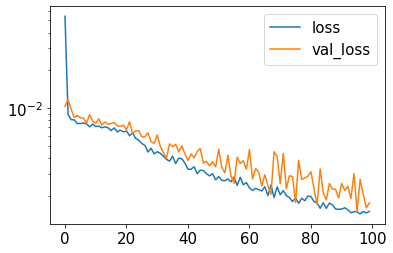

In [111]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.yscale("log")
plt.legend()
plt.show()


In [21]:
# import tensorflow as tf
# model = tf.keras.models.load_model("/work/data_science/kishan/surrogate_ldrd/lstm_tracking")


In [112]:
preds = model.predict_on_batch(val_x)


In [113]:
preds.shape

(382140, 6)

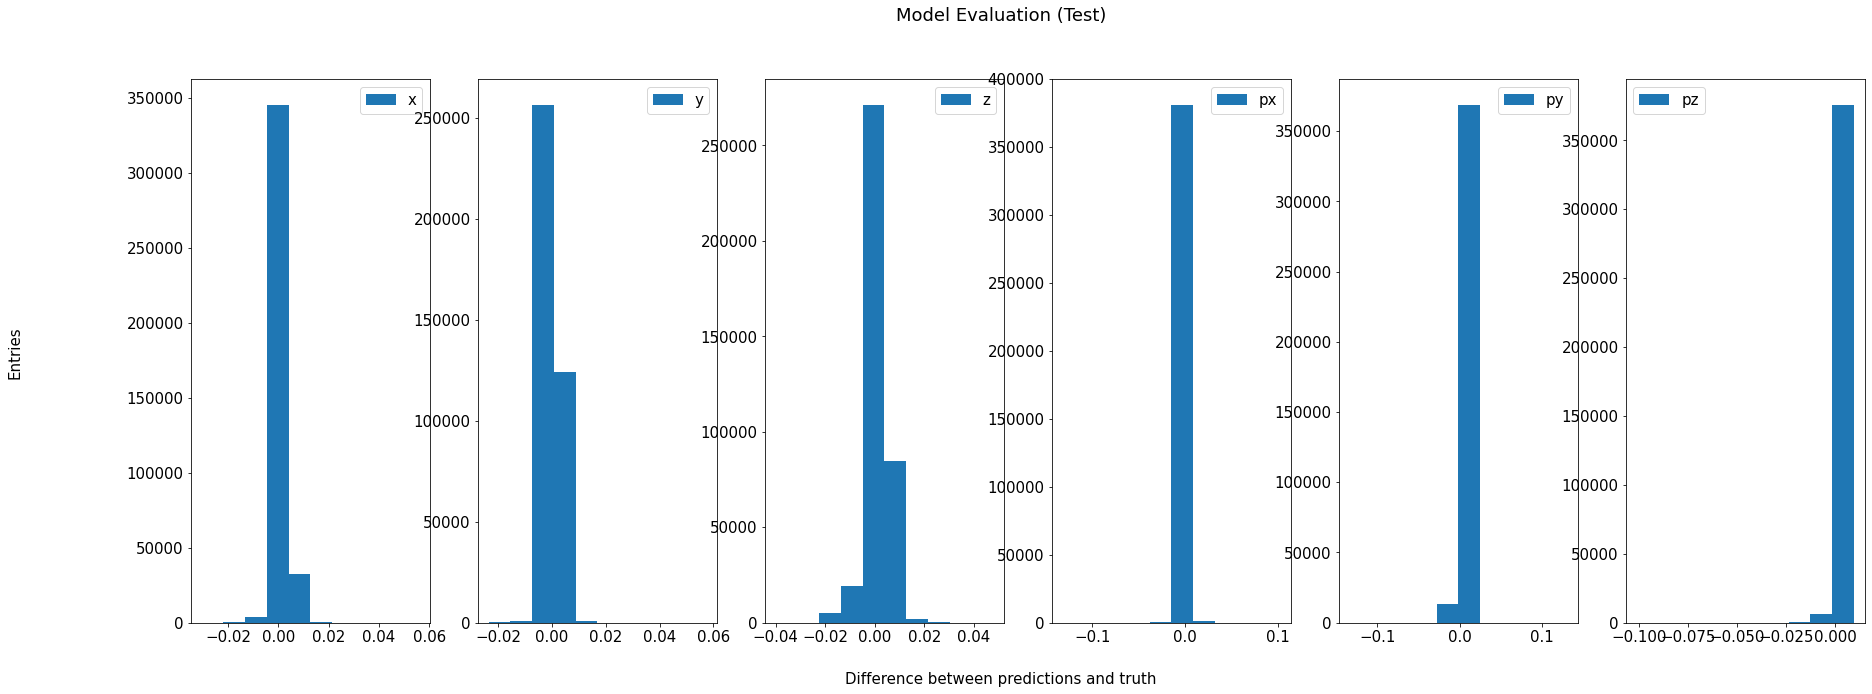

In [114]:
plt.rcParams.update({'font.size': 15})
labels = ['x', 'y', 'z', 'px', 'py', 'pz']
fig, ax = plt.subplots(1, 6, figsize=(30,10))
fig.suptitle('Model Evaluation (Test)')
for i in range(6):
    ax[i].hist(val_y[:, i]-preds[:, i], label=labels[i])
#     ax[0, i].xlabel("Difference between truth and prediction")
#     ax[0, i].ylabel("Entries")
    ax[i].legend()
#     ax[1, i].xlabel("")
#     ax[1, i].ylabel("Entries")
fig.text(0.5, 0.04, 'Difference between predictions and truth', ha='center')
fig.text(0.04, 0.5, 'Entries', va='center', rotation='vertical')
plt.show()

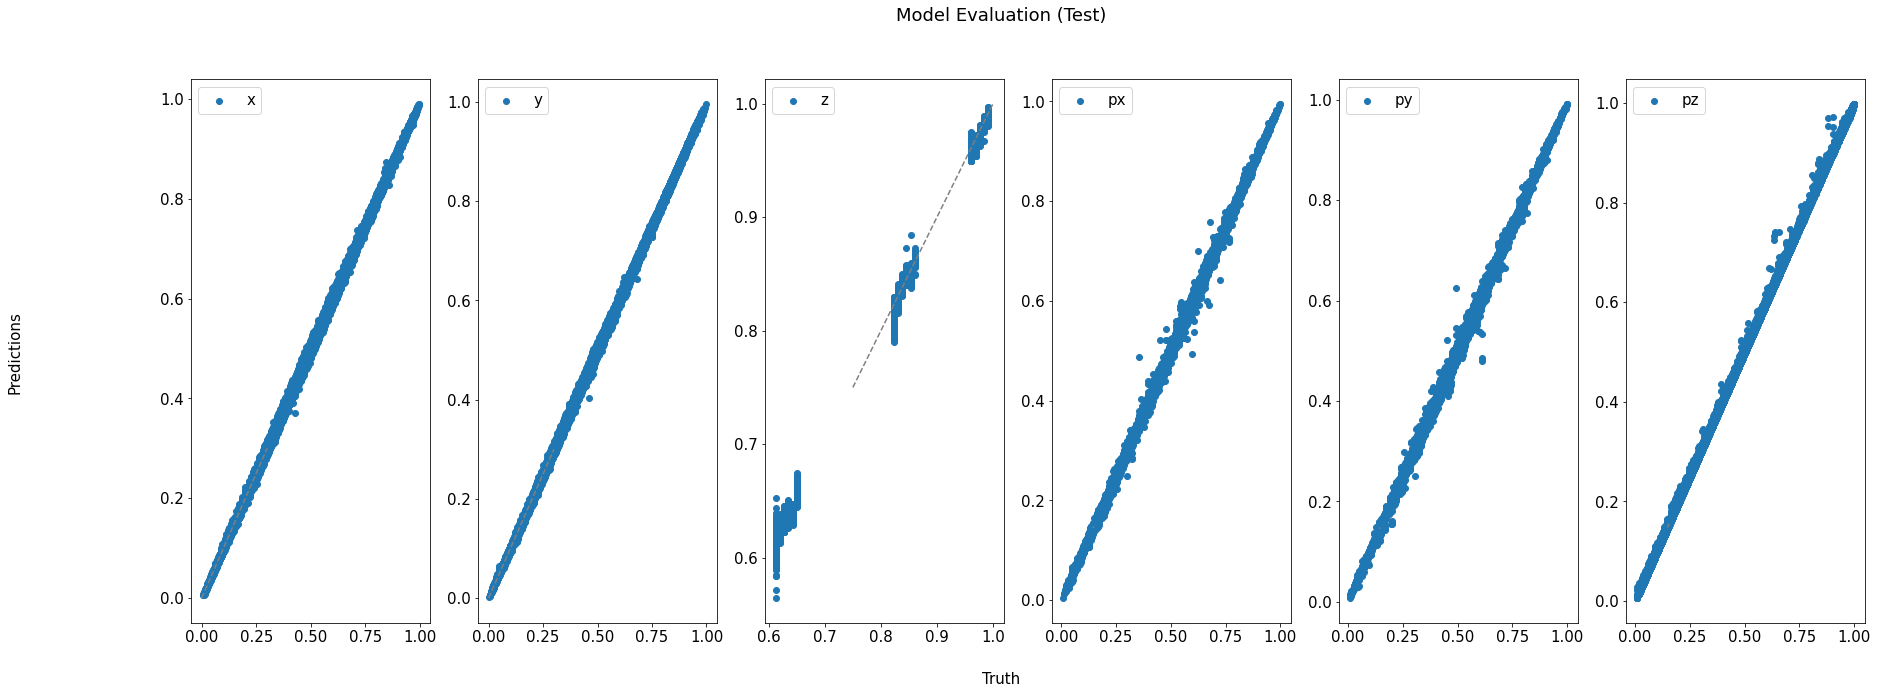

In [115]:
fig, ax = plt.subplots(1, 6, figsize=(30,10))
fig.suptitle('Model Evaluation (Test)')
for i in range(6):
    ax[i].scatter(val_y[:, i], preds[:, i], label=labels[i])
    ident = [0.0, 0.3]
    if i == 2:
        ident = [0.75, 1.0]
    if i>2 and i<5:
        ident = [0.145, 0.148]
    if i>=5:
        ident = [0.1475, 0.155]
    ax[i].plot(ident,ident, "--", color='gray')
    ax[i].legend()
fig.text(0.5, 0.04, 'Truth', ha='center')
fig.text(0.04, 0.5, 'Predictions', va='center', rotation='vertical')
plt.show()

In [78]:
# print(mn, mx)
# new_mn = mn - 5
# new_mx = mx + 5

-58.8709 343.53


In [124]:
test_csv = pandas.read_csv("/work/halld2/home/kishan/AI Tracking/newTestData.csv")
# test_csv.dropna(inplace=True)
test_data = np.array(test_csv)
test_data = np.reshape(test_data, (test_data.shape[0], 25, 6))
for i in range(test_data.shape[2]):
    test_data[:, :, i] = (test_data[:, :, i] - mn[i]) / (mx[i] - mn[i])
    print(test_data[:, :, i].min(), test_data[:, :, i].max())


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


In [125]:
np.where(test_data>1)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [126]:
test_data.shape

(14601, 25, 6)

In [127]:
preds = []
truth = []
for i in range(test_data.shape[0]):
    if i>=3000 and i%100 == 0: #i%1000 == 0:
        print(i)
    arr = test_data[i:i+1]
    if np.isnan(arr[:, :8, :]).any():
        continue
    flag = False
    for j in range(8, 25):
        if np.isnan(arr[:, j, :]).any():
            pred = model.predict_on_batch(arr[:, j-8:j, :])
            arr[:, j, :] = pred[0]
            flag = True
        elif flag:
            pred = model.predict_on_batch(arr[:, j-8:j, :])
            preds.append(pred[0])
            truth.append(arr[0, j, :])
    if i >=3500:
        break
        

3000
3100
3200
3300
3400
3500


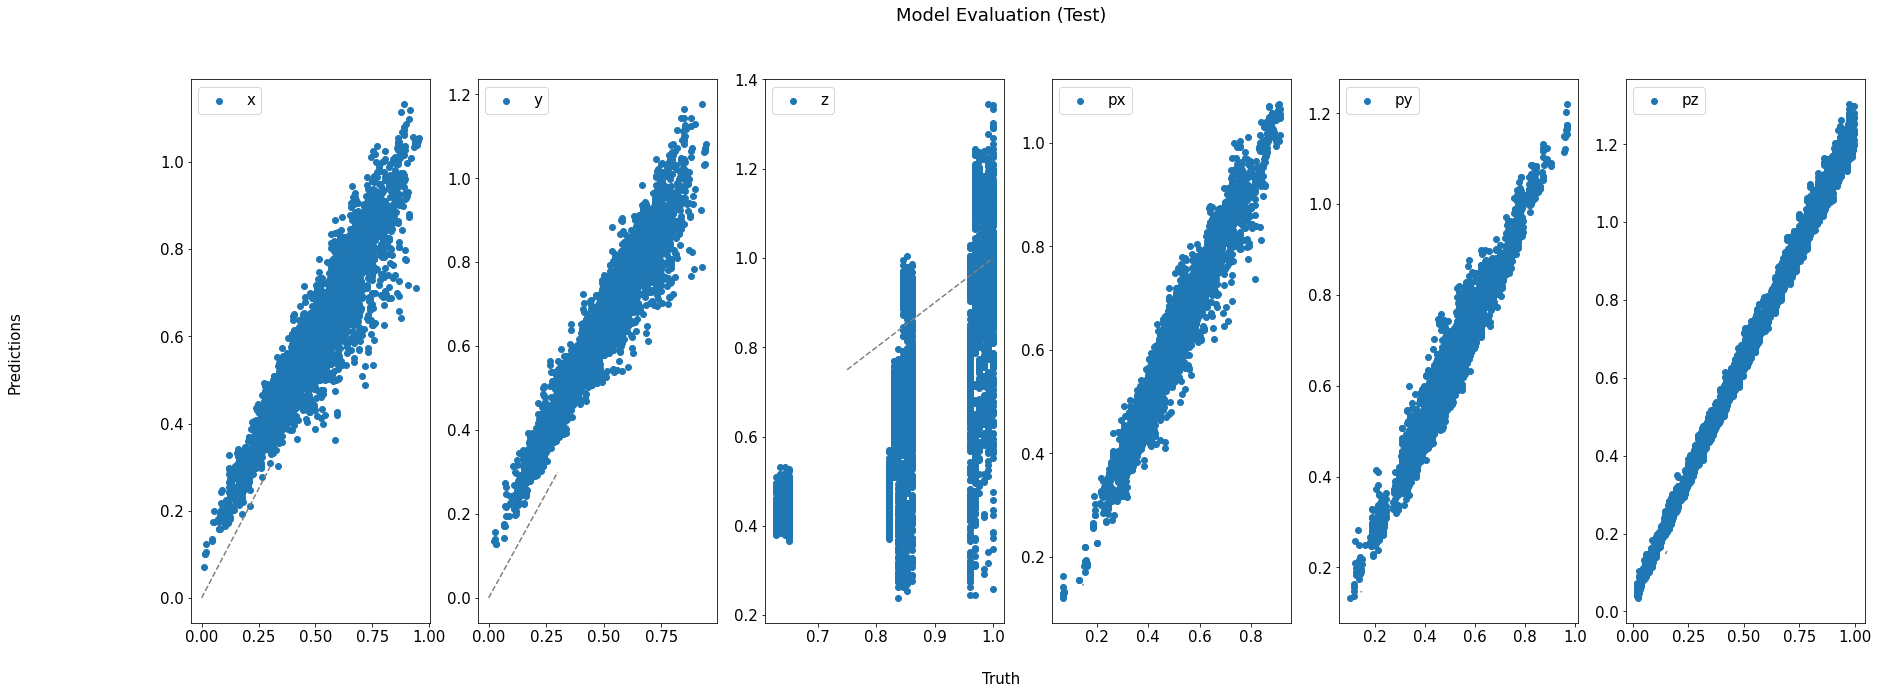

In [128]:
preds = np.array(preds)
truth = np.array(truth)
fig, ax = plt.subplots(1, 6, figsize=(30,10))
fig.suptitle('Model Evaluation (Test)')
for i in range(6):
    ax[i].scatter(truth[:, i], preds[:, i], label=labels[i])
    ident = [0.0, 0.3]
    if i == 2:
        ident = [0.75, 1.0]
    if i>2 and i<5:
        ident = [0.145, 0.148]
    if i>=5:
        ident = [0.1475, 0.155]
    ax[i].plot(ident,ident, "--", color='gray')
    ax[i].legend()
fig.text(0.5, 0.04, 'Truth', ha='center')
fig.text(0.04, 0.5, 'Predictions', va='center', rotation='vertical')
plt.show()